<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/transfer-learning/ResNet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tasks:

- Import the pre-trained ResNet-18
- Freeze the model & fine-tune the output layer only
- Test the categorization performance of Resnet 18 on STL10 dataset
  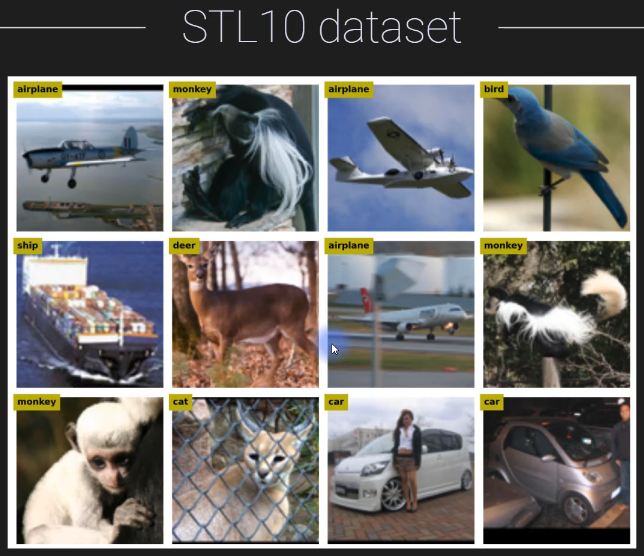

In [1]:
# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [2]:
# use GPU if available (beneficial for larger model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# Import the dataset:

In [4]:
# Note: ResNet is trained for images in a specific range (not [-1,1] anymore, around [-2, 2] instead).
# That changes the mean/std normalization values in the transform.
# Ref: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

# transformations
transform = T.Compose([
    T.ToTensor(), # normalize from [0, 255] -> [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # (mean, std), further normalization
])

# import the train/test set & simultaneously apply the transformations
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform) # split='train' -> train set
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform) # split='test' -> test set
# print(type(testset)) # class 'torchvision.datasets.stl10.STL10'

# transform to DataLoaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

100%|██████████| 2640397119/2640397119 [03:02<00:00, 14430138.70it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
X,y = next(iter(train_loader))
# again: shape
print( X.data.shape ) # batchsize = 32

# again: the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


👆 When we actually pull data out of the DataLoader, the normalization gets applied 🎉

NOTE: The ResNet model is trained for 1000 categories, therefore we have to modify the ResNet architecture to have 10 output nodes instead of 1000.

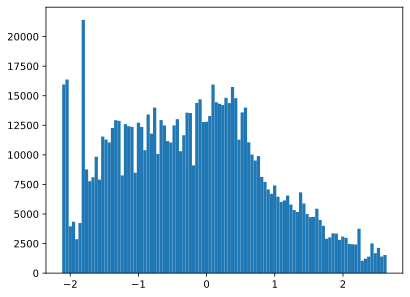

In [7]:
# histogram of values within X with 100 bins
plt.hist(X.data.numpy().flatten(),100); # `;` suppresses the output of the plot generated by the `plt.hist()` function

👆 kind of Gaussian-ish

❌ -1.6505601
❌ 2.622571
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.6051416
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.64
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.0125492
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.64
✅ 0.0
✅ 1.0
❌ -2.0836544
❌ 2.64
✅ 0.0
✅ 1.0
❌ -2.0494049
❌ 2.4134207
✅ 0.0
✅ 1.0
❌ -1.2616663
❌ 2.5877128
✅ 0.0
✅ 1.0
❌ -2.1007793
❌ 1.3502399
✅ 0.0
✅ 1.0
❌ -2.0494049
❌ 2.64
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.64
✅ 0.0
✅ 1.0
❌ -2.1007793
❌ 2.3935575
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.64
✅ 0.0
✅ 1.0
❌ -1.8267832
❌ 2.3262744
✅ 0.0
✅ 1.0
❌ -2.117904
❌ 2.64
✅ 0.0
✅ 1.0
❌ -1.843908
❌ 2.64
✅ 0.0
✅ 1.0


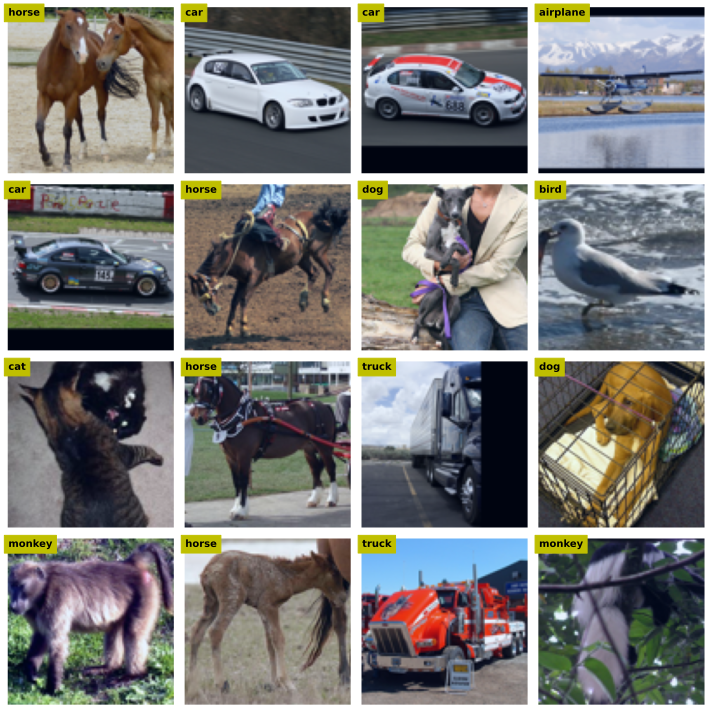

In [8]:
# inspect a few random images:

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0)) # (3, 32, 32) -> (32, 32, 3)
  print( "❌", np.min(pic) )
  print( "❌", np.max(pic) )

  # bring range back to [0, 1], eg: [3, 9] -> [0, 6] -> [0, 1]
  pic = pic-np.min(pic)
  pic = pic/np.max(pic) # np array
  print( "✅", np.min(pic) )
  print( "✅", np.max(pic) )

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Import & inspect the ResNet model:

In [9]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet = torchvision.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.4MB/s]


In [10]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# get an overview of this model:

from torchsummary import summary
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [12]:
# freeze all layers (will change the final layer later)
for p in resnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [13]:
# change the final layer
resnet.fc = nn.Linear(512,10)

In [16]:
# push the model to the GPU (if using)
resnet.to(device); # `;` suppresses the output

# Train the model:

In [18]:
# loss func & optimizer
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.001,momentum=.9)
# the momentum update will be 90% of the previous update + 10% of the gradient computed for the current batch
# the previous values are weighted less and less as training progresses (dampened prev gradients)

In [19]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1/10. Test accuracy = 74.52%
Finished epoch 2/10. Test accuracy = 76.20%
Finished epoch 3/10. Test accuracy = 76.95%
Finished epoch 4/10. Test accuracy = 77.99%
Finished epoch 5/10. Test accuracy = 78.52%
Finished epoch 6/10. Test accuracy = 79.05%
Finished epoch 7/10. Test accuracy = 78.56%
Finished epoch 8/10. Test accuracy = 78.96%
Finished epoch 9/10. Test accuracy = 78.60%
Finished epoch 10/10. Test accuracy = 79.14%


# Visualize the performance:

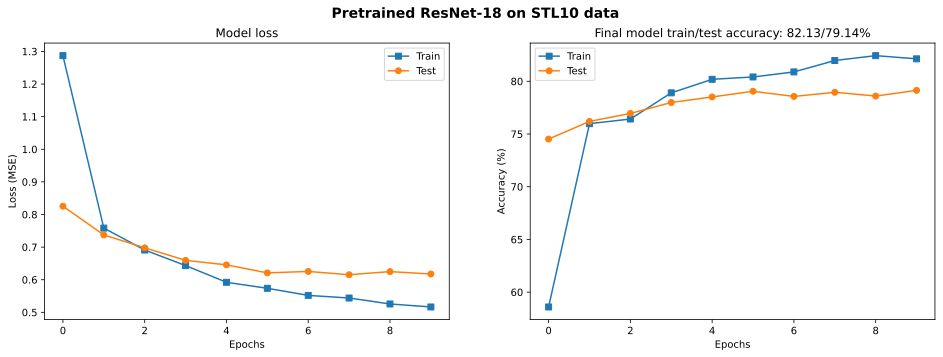

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

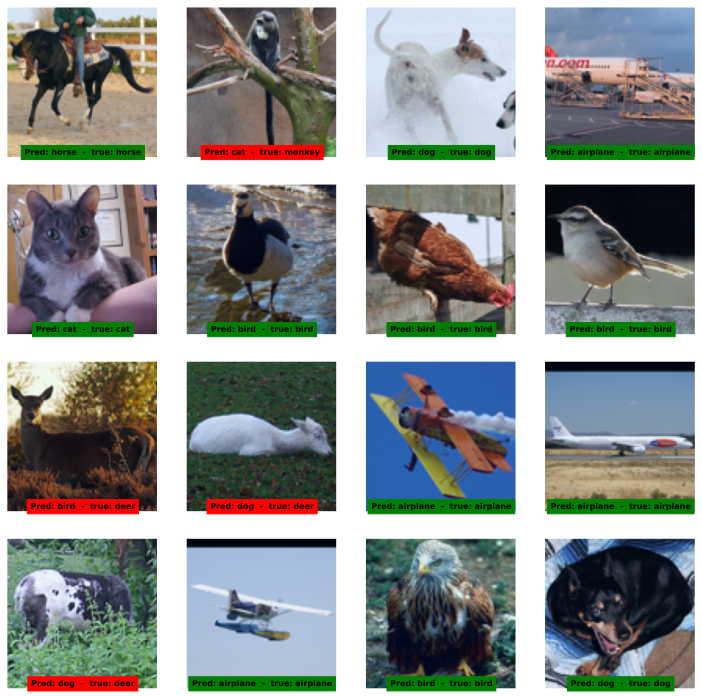

In [22]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()